# Introduction

The assignment is focused on solving the Forest Cover Type Prediction: https://www.kaggle.com/c/forest-cover-type-prediction/overview. This task proposes a classification problem: predict the forest cover type (the predominant kind of tree cover) from strictly cartographic variables (as opposed to remotely sensed data).

The study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado. Each observation is a 30m x 30m patch. You are asked to predict an integer classification for the forest cover type. The seven types are:

1. Spruce/Fir
2. Lodgepole Pine
3. Ponderosa Pine
4. Cottonwood/Willow
5. Aspen
6. Douglas-fir
7. Krummholz

The training set (15120 observations) contains both features and the Cover_Type. The test set contains only the features. 

**You must predict the Cover_Type for every row in the test set (565892 observations).**

___
**Importing Libraries and Modules**

In [1]:
#General Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy import array 
import warnings
warnings.filterwarnings('ignore')

#sklearn Models
from sklearn import linear_model
from sklearn import tree, ensemble
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

#sklearn Others
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix


#Random State
rand_state = 42

# 1) Exploratory Analysis

### a. Importing the Dataset

In [2]:
dataset = pd.read_csv("train.csv")

dataset.head()

Id  Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0   1       2596      51      3                               258   
1   2       2590      56      2                               212   
2   3       2804     139      9                               268   
3   4       2785     155     18                               242   
4   5       2595      45      2                               153   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                              510   
1                              -6                              390   
2                              65                             3180   
3                             118                             3090   
4                              -1                              391   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  ...  Soil_Type32  \
0            221             232            148  ...            0   
1            220             235            151  ...            0   
2            234             238            135  ...            0   
3            238             238            122  ...            0   
4            220             234            150  ...            0   

   Soil_Type33  Soil_Type34  Soil_Type35  Soil_Type36  Soil_Type37  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Soil_Type38  Soil_Type39  Soil_Type40  Cover_Type  
0            0            0            0           5  
1            0            0            0           5  
2            0            0            0           2  
3            0            0            0           2  
4            0            0            0           5  

[5 rows x 56 columns]

In [3]:
#Drop index from the dataset
dataset.drop("Id", axis = 1,  inplace = True)

### b. Checking the Metadata and Balance

In [4]:
#Checking null values
dataset.isnull().sum()

Elevation                             0
Aspect                                0
Slope                                 0
Horizontal_Distance_To_Hydrology      0
Vertical_Distance_To_Hydrology        0
Horizontal_Distance_To_Roadways       0
Hillshade_9am                         0
Hillshade_Noon                        0
Hillshade_3pm                         0
Horizontal_Distance_To_Fire_Points    0
Wilderness_Area1                      0
Wilderness_Area2                      0
Wilderness_Area3                      0
Wilderness_Area4                      0
Soil_Type1                            0
Soil_Type2                            0
Soil_Type3                            0
Soil_Type4                            0
Soil_Type5                            0
Soil_Type6                            0
Soil_Type7                            0
Soil_Type8                            0
Soil_Type9                            0
Soil_Type10                           0
Soil_Type11                           0


There are no Null values.

In [5]:
#Checking the Metadata
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 55 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   Elevation                           15120 non-null  int64
 1   Aspect                              15120 non-null  int64
 2   Slope                               15120 non-null  int64
 3   Horizontal_Distance_To_Hydrology    15120 non-null  int64
 4   Vertical_Distance_To_Hydrology      15120 non-null  int64
 5   Horizontal_Distance_To_Roadways     15120 non-null  int64
 6   Hillshade_9am                       15120 non-null  int64
 7   Hillshade_Noon                      15120 non-null  int64
 8   Hillshade_3pm                       15120 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  15120 non-null  int64
 10  Wilderness_Area1                    15120 non-null  int64
 11  Wilderness_Area2                    15120 non-null  int64
 12  Wild

All values are integers

In [6]:
#Checking Unique Values
print(dataset.nunique())

Elevation                             1665
Aspect                                 361
Slope                                   52
Horizontal_Distance_To_Hydrology       400
Vertical_Distance_To_Hydrology         423
Horizontal_Distance_To_Roadways       3250
Hillshade_9am                          176
Hillshade_Noon                         141
Hillshade_3pm                          247
Horizontal_Distance_To_Fire_Points    2710
Wilderness_Area1                         2
Wilderness_Area2                         2
Wilderness_Area3                         2
Wilderness_Area4                         2
Soil_Type1                               2
Soil_Type2                               2
Soil_Type3                               2
Soil_Type4                               2
Soil_Type5                               2
Soil_Type6                               2
Soil_Type7                               1
Soil_Type8                               2
Soil_Type9                               2
Soil_Type10

Soil_Type7 and Soil_Type 15 are booleans but only have 1 value, meaning they are constant. They will not help us in our prediction and should be removed.

In [7]:
#Checking the Balance
y = dataset["Cover_Type"]
y.value_counts()

1    2160
2    2160
3    2160
4    2160
5    2160
6    2160
7    2160
Name: Cover_Type, dtype: int64

The dataset is perfectly balanced

### c. Separating Categorical Variables from Non-Categorical Variables

In [8]:
cat_features = [col for col in dataset.columns if 'Type' in col or  'Area' in col]
non_cat_features = [col for col in dataset.columns if col not in cat_features]

### d. Visualizing the Non-Categorical data 

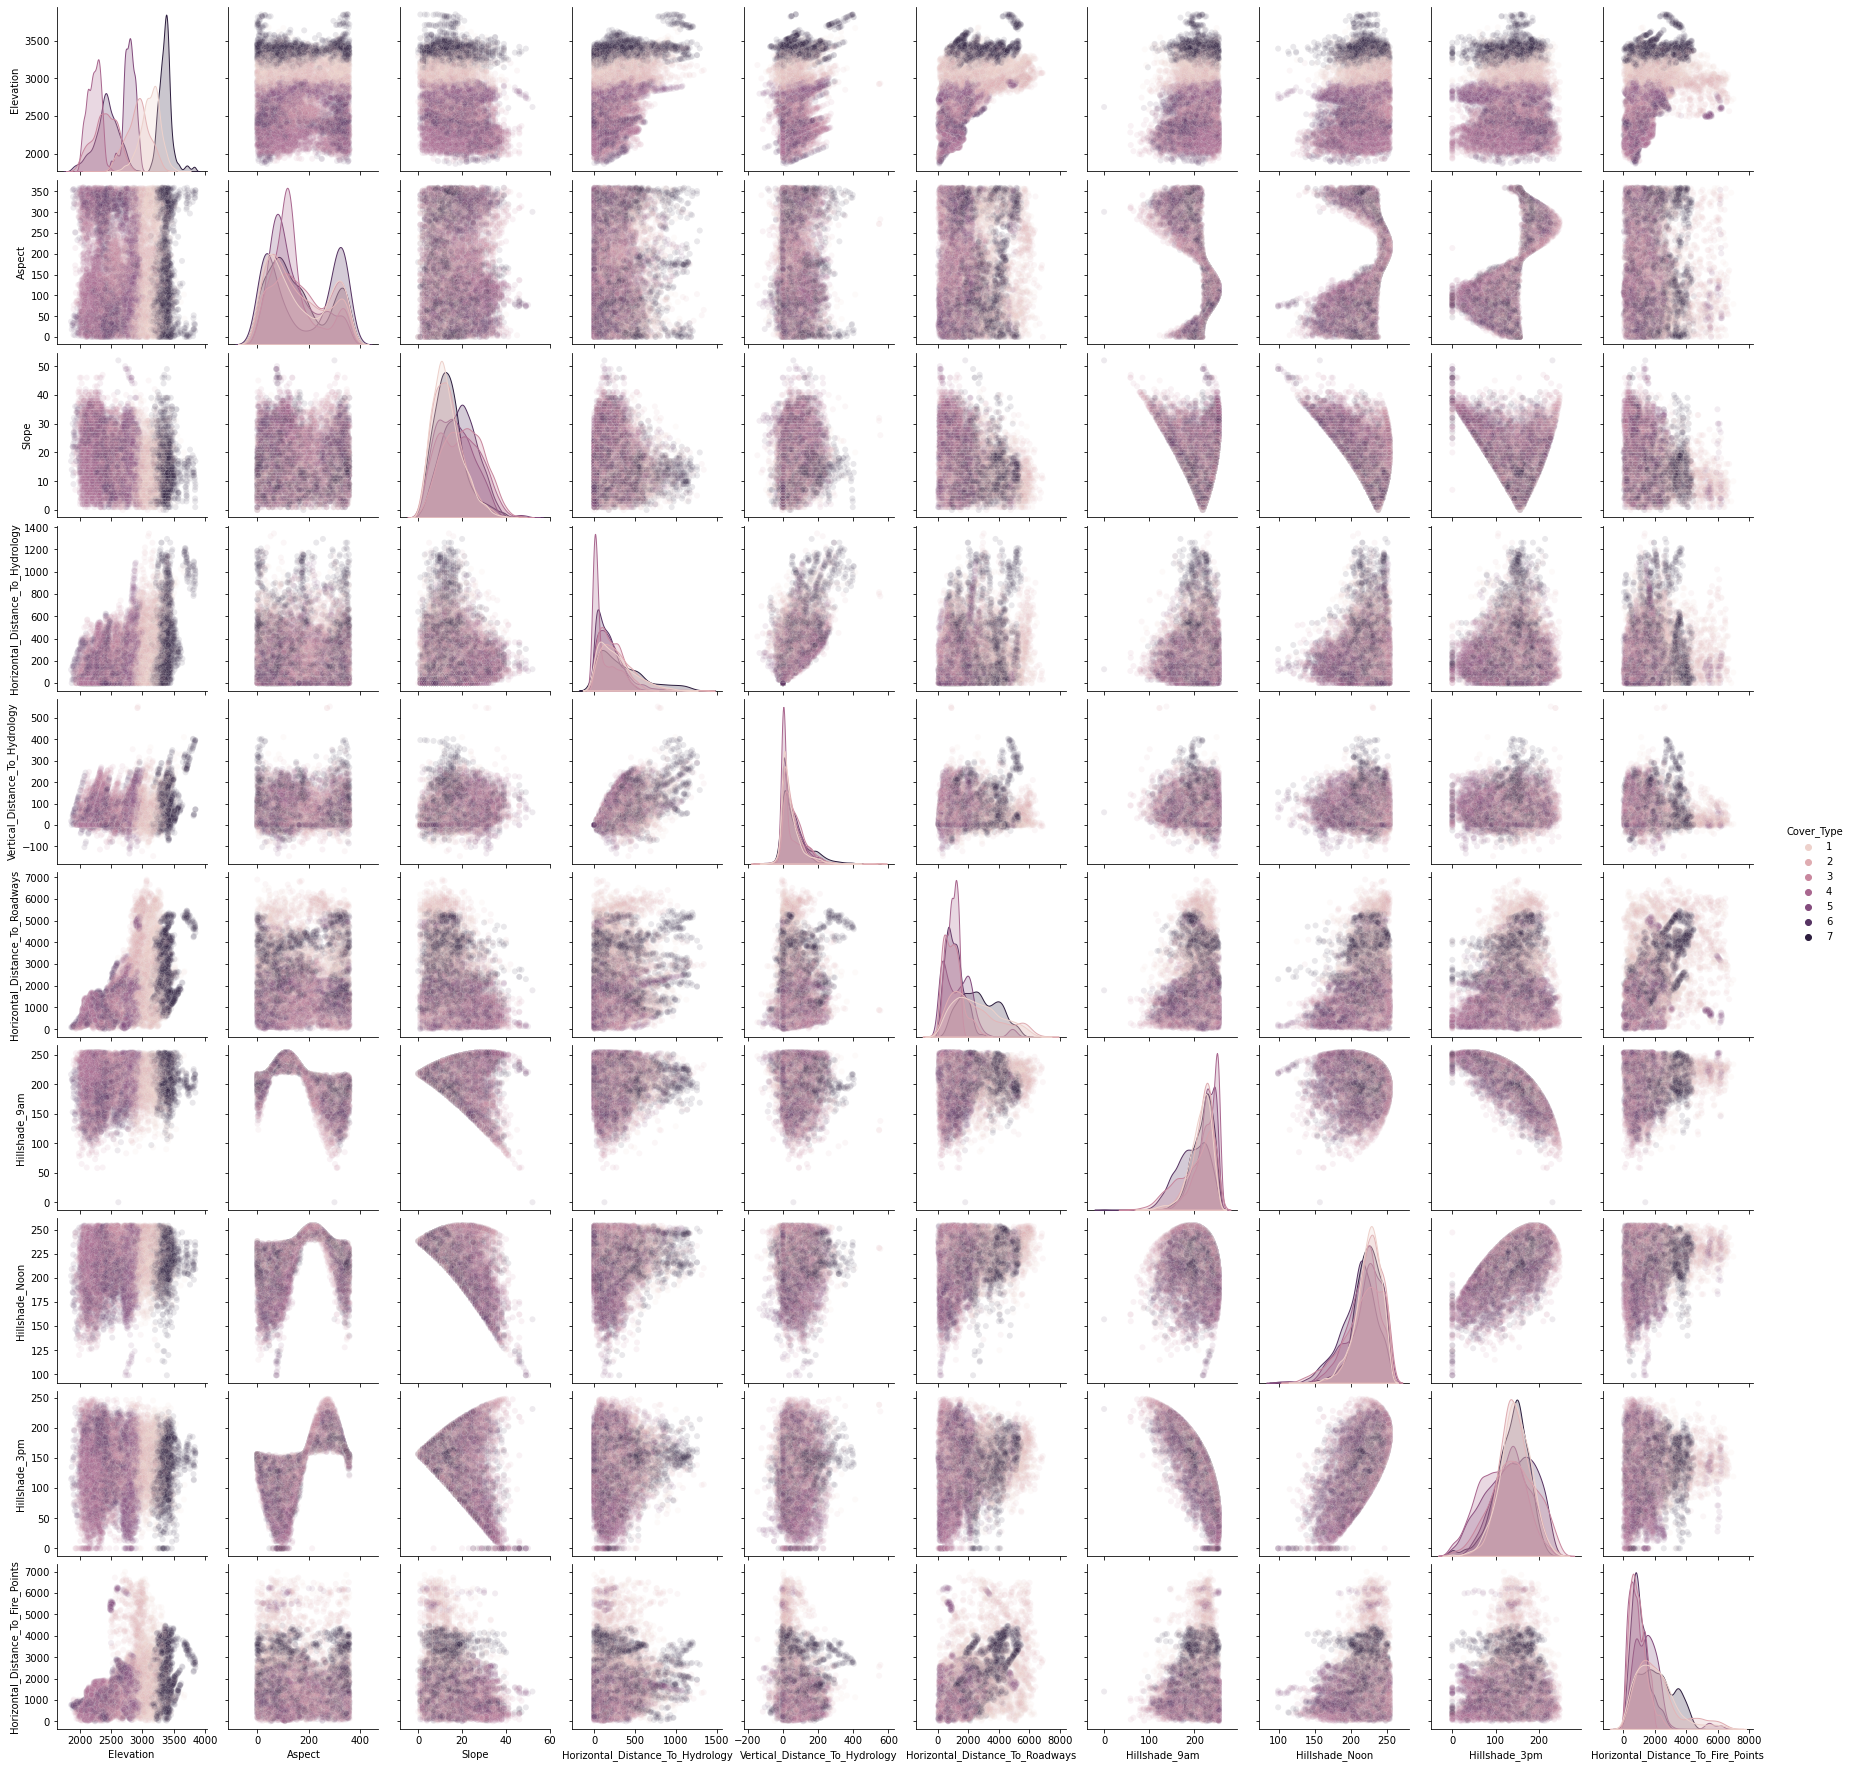

In [9]:
#Plotting Distributions
sns.pairplot(dataset[["Cover_Type"] + non_cat_features], hue="Cover_Type", plot_kws = {'alpha': 0.1} )

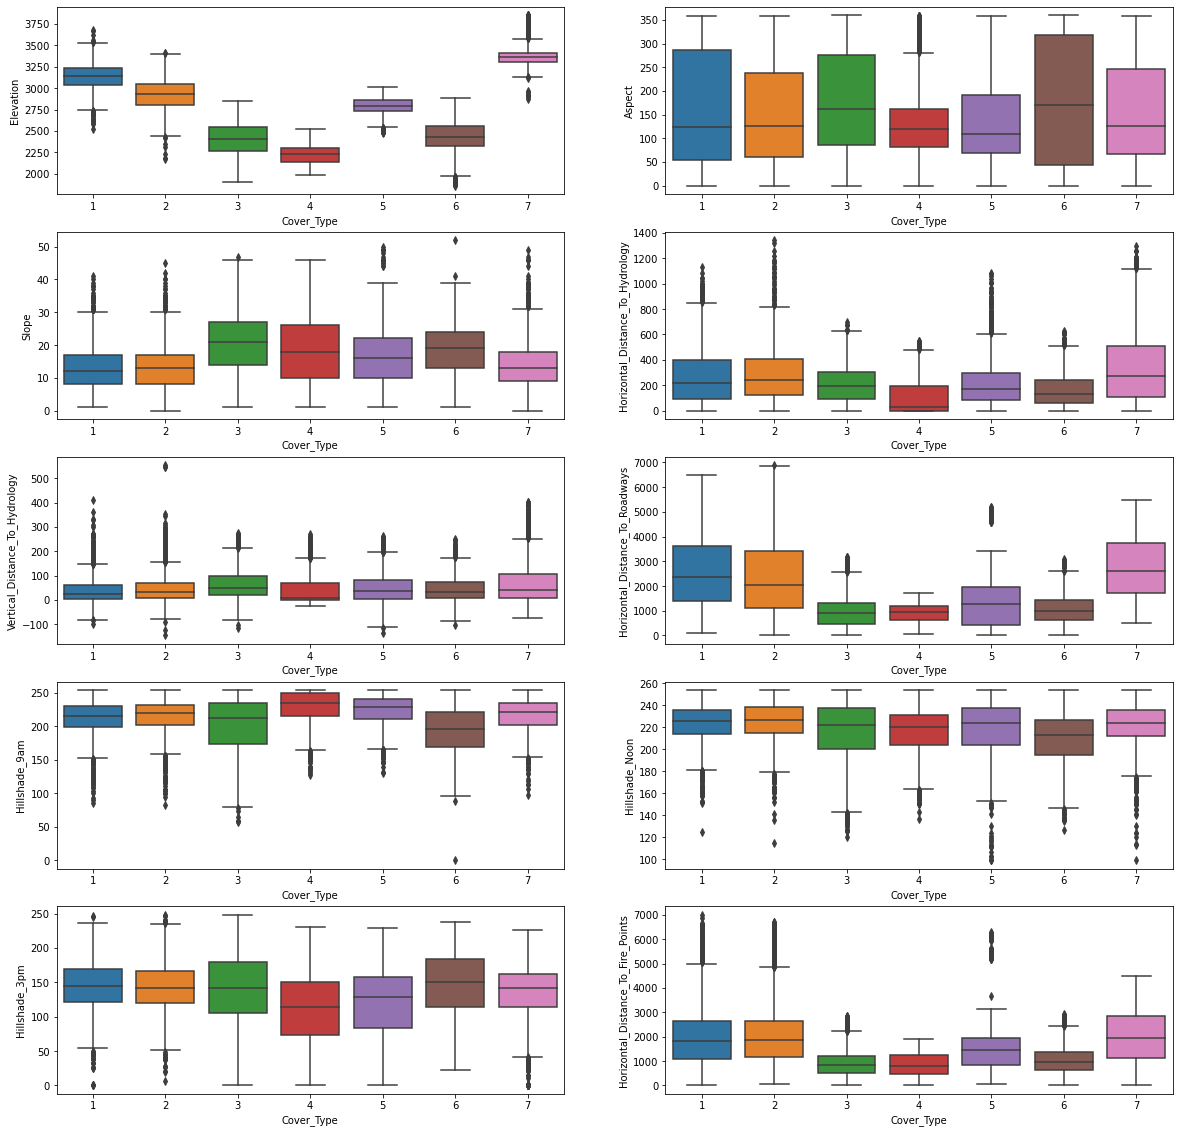

In [10]:
#Box Plots
columns = non_cat_features

fig, ax = plt.subplots(5,2, figsize = (20,20))
ax = ax.ravel()

for col in columns: 
    sns.boxplot(dataset["Cover_Type"], dataset[col], ax = ax[columns.index(col)])

Every non-categorical feature has at least one class with outliers. The furthest outliers should be removed in order not to be taken into account by the algorithms.

### e. Visualizing the Categorical data 

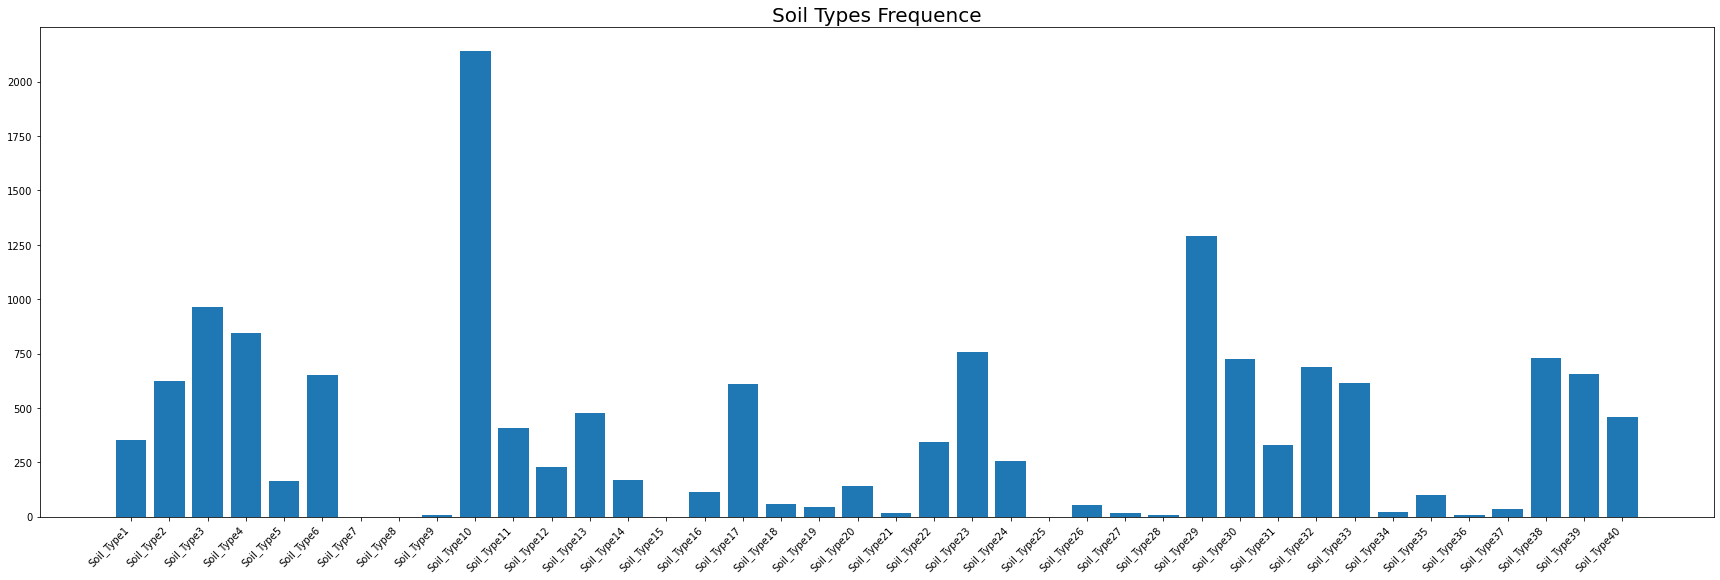

In [11]:
fig, axes = plt.subplots(figsize=(30,9))
x = [cat for cat in cat_features if "Soil" in cat]

axes.bar(x, height = dataset[x].sum());
plt.xticks(rotation=45, ha='right');
plt.title("Soil Types Frequence", fontsize=20);

Some Soil Types are barely represented in the dataset (#7 to #9, #15, #21, #25, #27, #28, #34, #36). They might not be helpful for our prediction.

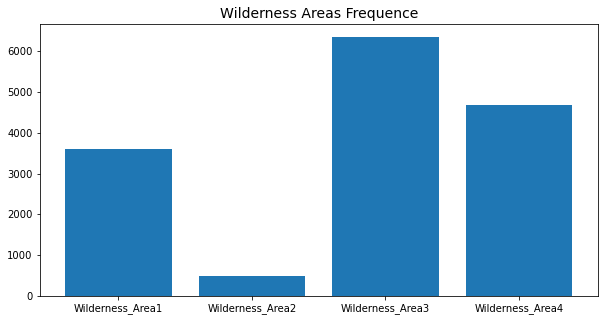

In [12]:
fig, axes = plt.subplots(figsize=(10,5))
x2 = [cat for cat in cat_features if "Wild" in cat]

axes.bar(x2, height = dataset[x2].sum());
plt.title("Wilderness Areas Frequence", fontsize=14);

Wilderness_Area2 is not as represented as the other types in the dataset

### f. Checking Features Correlation

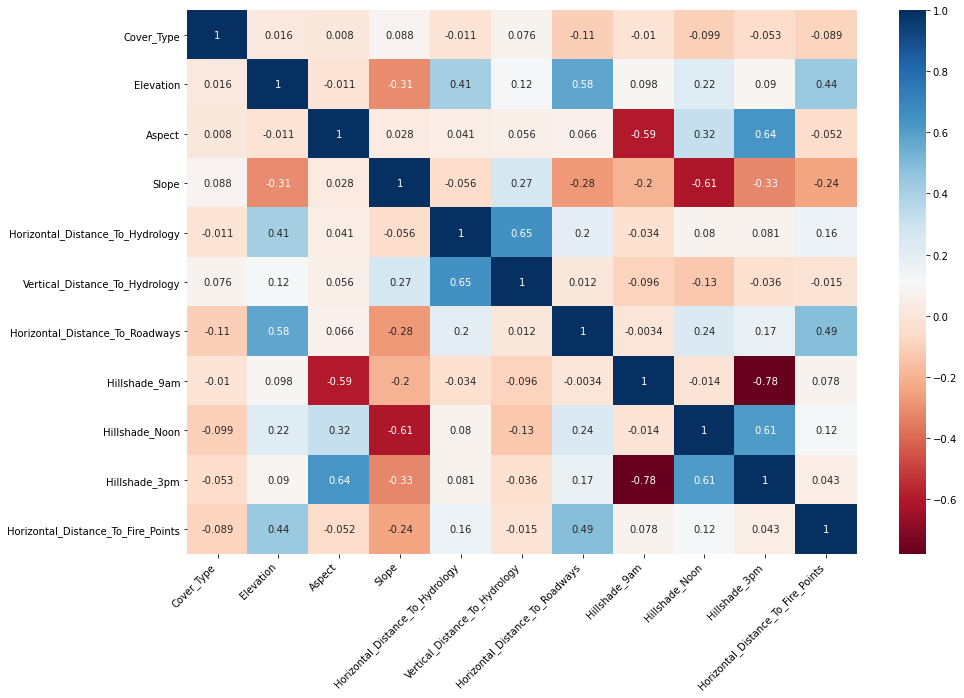

In [13]:
#Correlation heatmap
fig, ax = plt.subplots(figsize=(15,10)) 
sns.heatmap(dataset[["Cover_Type"] + non_cat_features].corr(), cmap="RdBu", annot=True, ax=ax)
plt.xticks(rotation=45, ha='right');

Some features are highly correlated. They should be removed or transformed to not bias our prediction.

# 2) Data Engineering

### a. Removing Obvious Unrelevant Features 

As explained above, Soil_Type7 and Soil_Type 15 are constant and will not help predicting the Covert_Type class. They are removed.

In [14]:
dataset[["Soil_Type7", "Soil_Type15"]].describe()

Soil_Type7  Soil_Type15
count     15120.0      15120.0
mean          0.0          0.0
std           0.0          0.0
min           0.0          0.0
25%           0.0          0.0
50%           0.0          0.0
75%           0.0          0.0
max           0.0          0.0

In [15]:
dataset.drop(["Soil_Type7", "Soil_Type15"], axis = 1,  inplace = True)

### b. Removing Outliers

Outliers above Q3 + mulitplier* IQR and below Q1 - mulitplier* IQR are removed.

In [16]:
#Checking outliers
multipier = 2 #IQR multiplier threshold to define outliers

cover_type_values = [1, 2, 3, 4, 5, 6, 7]
outliers = pd.DataFrame()

for i in cover_type_values:
    Q1 = dataset[columns].where(dataset["Cover_Type"] == i).quantile(0.25)
    Q3 = dataset[columns].where(dataset["Cover_Type"] == i).quantile(0.75)
    IQR = Q3 - Q1
    IQR
    
    #Count outliers in a dataframe
    count = ((dataset[columns].where(dataset["Cover_Type"] == i) < (Q1 - multipier * IQR)) | (dataset[columns].where(dataset["Cover_Type"] == i) > (Q3 + multipier * IQR))).sum()
    
    outliers[str(i)] = count
    
outliers["total"] = outliers[list(outliers.columns)].sum(axis=1)
outliers["%"] = (outliers["total"]/len(dataset))*100
outliers.loc['total']= outliers.sum()

In [17]:
outliers

1      2     3      4      5     6  \
Elevation                            11.0    4.0   0.0    0.0    0.0   0.0   
Aspect                                0.0    0.0   0.0  166.0    0.0   0.0   
Slope                                 8.0    9.0   0.0    0.0    7.0   1.0   
Horizontal_Distance_To_Hydrology      5.0   22.0   0.0    0.0   47.0   5.0   
Vertical_Distance_To_Hydrology       90.0   67.0   6.0   29.0   14.0  17.0   
Horizontal_Distance_To_Roadways       0.0    0.0   8.0    0.0   17.0   5.0   
Hillshade_9am                        41.0   34.0   0.0    9.0    8.0   1.0   
Hillshade_Noon                       22.0   16.0   1.0    2.0   16.0   1.0   
Hillshade_3pm                         7.0    5.0   0.0    0.0    0.0   0.0   
Horizontal_Distance_To_Fire_Points   40.0   84.0  15.0    0.0   68.0  10.0   
total                               224.0  241.0  30.0  206.0  177.0  40.0   

                                        7   total         %  
Elevation                            71.0    86.0  0.568783  
Aspect                                0.0   166.0  1.097884  
Slope                                25.0    50.0  0.330688  
Horizontal_Distance_To_Hydrology      0.0    79.0  0.522487  
Vertical_Distance_To_Hydrology       37.0   260.0  1.719577  
Horizontal_Distance_To_Roadways       0.0    30.0  0.198413  
Hillshade_9am                        10.0   103.0  0.681217  
Hillshade_Noon                       25.0    83.0  0.548942  
Hillshade_3pm                        21.0    33.0  0.218254  
Horizontal_Distance_To_Fire_Points    0.0   217.0  1.435185  
total                               189.0  1107.0  7.321429

In [18]:
#Removing outliers
outliers_indexes = np.array([])

for i in cover_type_values:
    for j in non_cat_features:
        Q1 = dataset[j].where(dataset["Cover_Type"] == i).quantile(0.25)
        Q3 = dataset[j].where(dataset["Cover_Type"] == i).quantile(0.75)
        IQR = Q3 - Q1

        upper_outliers = np.where( (dataset[j] > (Q3+multipier*IQR)) & (dataset["Cover_Type"] == i))
        lower_outliers = np.where( (dataset[j] < (Q1-multipier*IQR)) & (dataset["Cover_Type"] == i))
        
        new_outliers = np.append(upper_outliers, lower_outliers)
        outliers_indexes = np.append(outliers_indexes, new_outliers)   

print(f' {len(np.unique(outliers_indexes))} outliers were removed, or {round(len(np.unique(outliers_indexes))/len(dataset)*100,1)} % of the data.')
dataset_no_outliers = dataset.drop(np.unique(outliers_indexes))

 966 outliers were removed, or 6.4 % of the data.


In [19]:
#Rechecking data balance
y = dataset_no_outliers["Cover_Type"]
y.value_counts()

3    2130
6    2121
7    2032
5    1993
1    1965
2    1957
4    1956
Name: Cover_Type, dtype: int64

The data remains pretty well balanced!<br/>     
We now check if outliers were removed by plotting two features, for example Horizontal_Distance_To_Hydrology with Elevation:

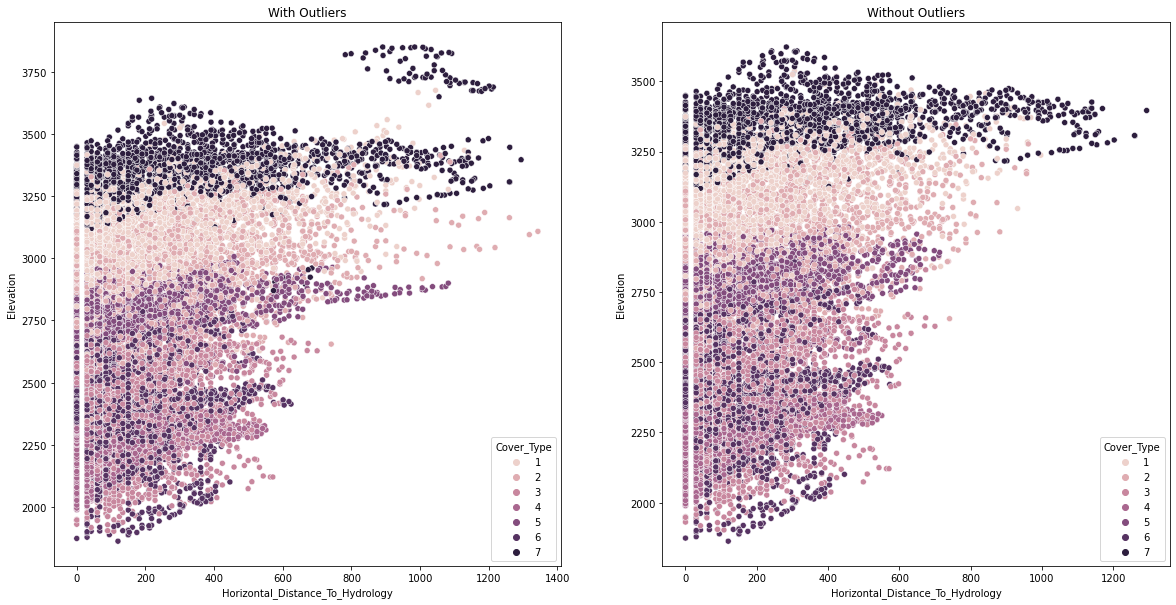

In [20]:
# Check if outliers are removed
fig, ax = plt.subplots(1,2, figsize = (20,10))
ax = ax.ravel()

with_out = sns.scatterplot(data=dataset, x="Horizontal_Distance_To_Hydrology", y="Elevation", hue="Cover_Type", ax=ax[0]);
with_out.set(title ="With Outliers");
without_out = sns.scatterplot(data=dataset_no_outliers, x="Horizontal_Distance_To_Hydrology", y="Elevation", hue="Cover_Type", ax=ax[1]);
without_out.set(title ="Without Outliers");

We now set the new dataset as the one without outliers:

In [21]:
dataset = dataset_no_outliers

### c. Splitting the Dataset

In [22]:
#Splitting the dataset
X = dataset.loc[:, dataset.columns != 'Cover_Type']
Y = dataset['Cover_Type']
    
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=rand_state)

In [23]:
#Checking if the differents subsets are still balanced:
print(y_train.value_counts())
print(y_test.value_counts())

6    1631
3    1618
5    1491
1    1478
4    1468
2    1467
7    1462
Name: Cover_Type, dtype: int64
7    570
3    512
5    502
2    490
6    490
4    488
1    487
Name: Cover_Type, dtype: int64


They remain pretty well balanced

## 3) Baseline Model

### a. Scaling and Fitting an algorithm
Regarding scaling, four methods will be tried:
* Standard Scaler
* Robust Scaler
* MinMax Scaler
* Normalizer

For each scaling method, a logistic regression model with no penalty will be fitted to compare the accuracies.

In [24]:
#Scaling non categorical features
scalers = [StandardScaler(), RobustScaler(), MinMaxScaler(), Normalizer()]

for scaler in scalers:
    transformer = ColumnTransformer(
    [
        (
            str(scaler),
            scaler,
            non_cat_features
        )
    ],
    remainder="passthrough"
    )

    pipe = Pipeline([
    ("scaler", transformer),
    ("baseline_model", LogisticRegression(max_iter=1000, penalty='none', random_state = rand_state, multi_class = 'multinomial'))
    ])
    
    print(f'Baseline Model Accuracy with {scaler}: {round(np.mean(cross_val_score(pipe, x_train, y_train, cv=3))*100,2)}%')

Baseline Model Accuracy with StandardScaler(): 71.31%
Baseline Model Accuracy with RobustScaler(): 71.3%
Baseline Model Accuracy with MinMaxScaler(): 71.38%
Baseline Model Accuracy with Normalizer(): 67.06%


Checking if the use of PCA could increase the accuracy:

In [25]:
#PCA assumes standardized data
transformer = ColumnTransformer(
[
    (
        "Standardize",
        StandardScaler(),
        non_cat_features
    )
],
remainder="passthrough"
)

pipe = Pipeline([
("scaler", transformer),
("PCA", PCA(n_components = 0.95)),
("baseline_model", LogisticRegression(max_iter=1000, penalty='none', random_state = rand_state, multi_class = 'multinomial'))
])

print(f'Baseline Model Accuracy with StandardScaler() and PCA: {round(np.mean(cross_val_score(pipe, x_train, y_train, cv=3))*100,2)}%')

Baseline Model Accuracy with StandardScaler() and PCA: 69.3%


Checking that the pipeline worked by passing non-scaled data into the same logistic regression model:

In [26]:
baseline_model_no_scaling = LogisticRegression(max_iter=1000, penalty='none', random_state = rand_state, multi_class = 'multinomial')

print(f'We should expect a lower accuracy score without scaling.')
print(f'Baseline Model Accuracy without scaling: {round(np.mean(cross_val_score(baseline_model_no_scaling, x_train, y_train, cv=5))*100,2)}%')

We should expect a lower accuracy score without scaling.
Baseline Model Accuracy without scaling: 61.63%


## 4) Improving the Model
### a. Generating New Features
After research, several features that were identified as highly correlated in part 1.f) appear to be linked to each other. <br/>  
For example, "Horizontal_Distance_To_Hydrology" and "Vertical_Distance_To_Hydrology" which have a correlation of 0.65 were computed into one single variable "Hypotenuse_Distance_To_Hydrology" using Pythagoras' theorem:

In [27]:
def hypotenuse_distance_to_hydrology(dataset, Horizontal_Distance_To_Hydrology, Vertical_Distance_To_Hydrology):
    hypo = round(((Horizontal_Distance_To_Hydrology**2+Vertical_Distance_To_Hydrology**2)**0.5), 3) 
    
    return dataset.insert(0, 'Hypotenuse_Distance_To_Hydrology', hypo)

In [28]:
hypotenuse_distance_to_hydrology(dataset, dataset["Horizontal_Distance_To_Hydrology"], dataset["Vertical_Distance_To_Hydrology"])

Another finding was about the close relationship between "Hillshade", "Slope" and "Aspect" in topology. By combining "Slope" and "Aspect", it is possible to find the solar radiation (the opposite of a hillshade) a piece of land receives. Since the three "Hillshape" features are highly correlated with one another (0.61 and -0.78), it was decided to combine them into a coefficient:

In [29]:
def illumination_coef(dataset, Hillshade_9am, Hillshade_Noon, Hillshade_3pm):
    
    #Translating Hillshade into Illumination   
    Hillshade_9am = 255 - Hillshade_9am
    Hillshade_Noon = 255 - Hillshade_Noon
    Hillshade_3pm = 255 - Hillshade_3pm
    
    coef = (Hillshade_9am + Hillshade_Noon + Hillshade_3pm)/(sum(Hillshade_9am + Hillshade_Noon + Hillshade_3pm)/len(dataset))
    
    return dataset.insert(1,'Sun_Illumination', coef)

In [30]:
illumination_coef(dataset, dataset["Hillshade_9am"] , dataset["Hillshade_Noon"], dataset["Hillshade_3pm"])

Now that the two new features have been created and inserted in the dataset, we will remove the ones that gather similar information:

In [31]:
dataset.drop(["Hillshade_9am","Hillshade_Noon","Hillshade_3pm","Slope","Aspect","Horizontal_Distance_To_Hydrology","Vertical_Distance_To_Hydrology"], axis = 1,  inplace = True)

In [32]:
#Updating the non categorical features with the new features created and without the ones dropped
dropped_features = ["Hillshade_9am","Hillshade_Noon","Hillshade_3pm","Slope","Aspect","Horizontal_Distance_To_Hydrology","Vertical_Distance_To_Hydrology"]
generated_features = ["Hypotenuse_Distance_To_Hydrology", "Sun_Illumination"]

new_non_cat_features = [col for col in non_cat_features if col not in dropped_features]
new_non_cat_features.extend(generated_features)


Let's check the correlation between the updated features:

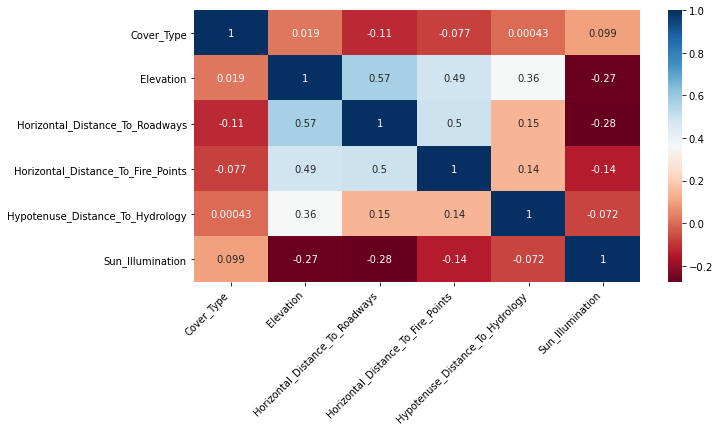

In [33]:
#Correlation heatmap
fig, ax = plt.subplots(figsize=(10,5)) 
sns.heatmap(dataset[["Cover_Type"] + new_non_cat_features].corr(), cmap="RdBu", annot=True, ax=ax)
plt.xticks(rotation=45, ha='right');

The highest correlation between two features does not exceed |0.6| !

### b. Splitting and Scaling the Updated Dataset
This scaling will be used to later determine which features to keep in the dataset (feature selection). For this step, we will use a robust scaler since some of our features are skewed:

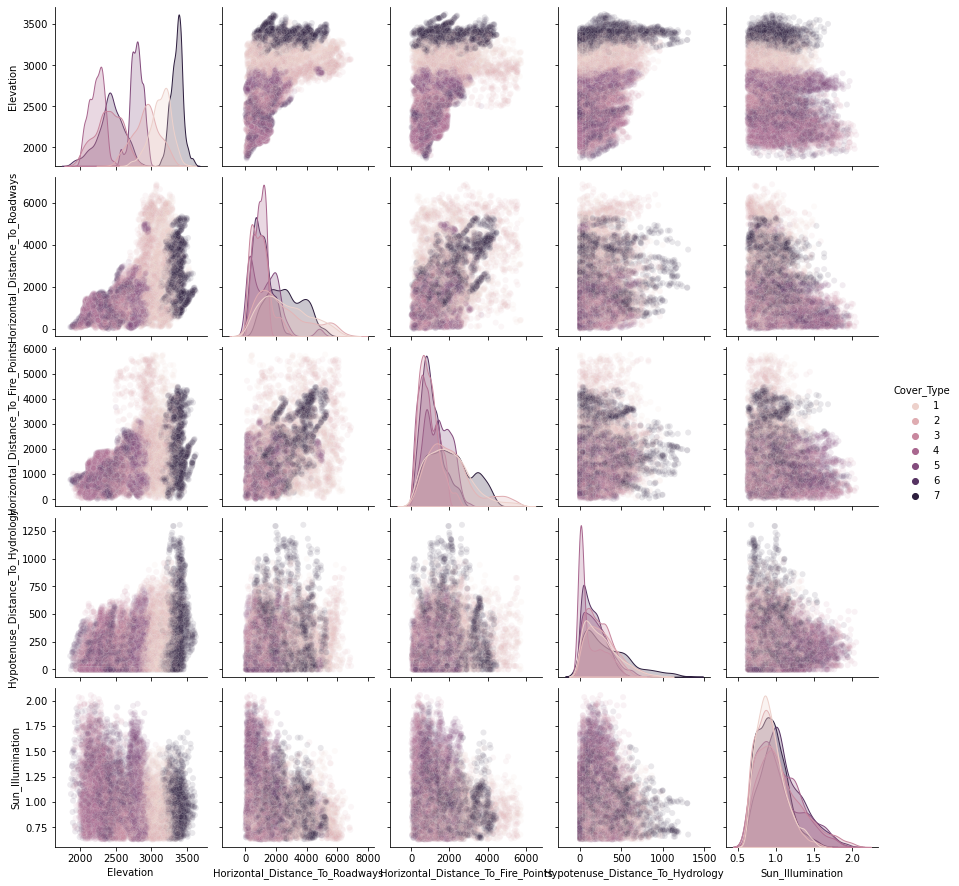

In [34]:
sns.pairplot(dataset[["Cover_Type"] + new_non_cat_features], hue="Cover_Type", plot_kws = {'alpha': 0.1} )

In [35]:
#Splitting the dataset
X = dataset.loc[:, dataset.columns != 'Cover_Type']
Y = dataset['Cover_Type']
    
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=rand_state)

In [36]:
#Scaling non categorical features
transformer = ColumnTransformer(
[
    (
        "RobustScaler()",
        RobustScaler(),
        new_non_cat_features
    )
],
remainder="passthrough"
)

In [37]:
#Apply transformation on train set:
x_train_robust = transformer.fit_transform(x_train)

#Apply transformation on test set (no fit)
x_test_robust = transformer.transform(x_test)


In [38]:
#Building new dataset
x_train_scaled = pd.DataFrame(
    x_train_robust,
    columns=x_train.columns
)

x_test_scaled = pd.DataFrame(
    x_test_robust,
    columns=x_test.columns
)

### c. Feature Selection
Two methods will be used to check which features are the best for our prediction:
* DecisionTreeClassifier.feature_importances_ using entropy measure
* SelectKBest()

**DecisionTreeClassifier.feature_importances_  :**

In [39]:
#DecisionTreeClassifier.feature_importances_
dt = tree.DecisionTreeClassifier(criterion = 'entropy', random_state=rand_state)
dt.fit(x_train_scaled, y_train);

In [40]:
feat_imp = dt.feature_importances_
features = x_train.columns

feat_imp_dt = pd.DataFrame({
    "feature": features,
    "importance": feat_imp
}).sort_values(by="importance", ascending=False).reset_index(drop=True)

feat_imp_dt.head(5)

feature  importance
0    Hypotenuse_Distance_To_Hydrology    0.565324
1                    Sun_Illumination    0.086056
2     Horizontal_Distance_To_Roadways    0.085476
3                           Elevation    0.083848
4  Horizontal_Distance_To_Fire_Points    0.052274

Let's check how many features account for 99% importance:

In [41]:
#Computing cumulative importance
prev_value = 0
cumulative_importance = []

for i in range(len(feat_imp_dt)):
    cumulative_importance.append(prev_value + feat_imp_dt["importance"][i]) 
    prev_value = prev_value + feat_imp_dt["importance"][i]

feat_imp_dt["cumulative_importance"] = cumulative_importance

In [42]:
#Finding which is the last relevant feature
last_important_feat = feat_imp_dt[feat_imp_dt["cumulative_importance"] <= 0.99].iloc[-1][0]

nbr_of_top_features = len(feat_imp_dt[feat_imp_dt["cumulative_importance"] <= 0.99])
print(f'{nbr_of_top_features} features are needed to reach an importance level of 99%')

25 features are needed to reach an importance level of 99%


In [43]:
feat_imp_dt.head(5)

feature  importance  cumulative_importance
0    Hypotenuse_Distance_To_Hydrology    0.565324               0.565324
1                    Sun_Illumination    0.086056               0.651380
2     Horizontal_Distance_To_Roadways    0.085476               0.736857
3                           Elevation    0.083848               0.820704
4  Horizontal_Distance_To_Fire_Points    0.052274               0.872979

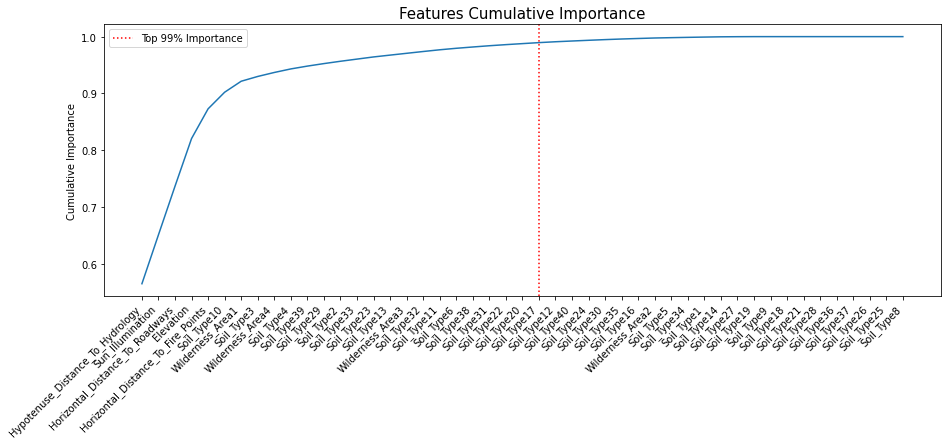

In [44]:
#Plotting features importance
fig = plt.subplots(figsize=(15,5))

plt.plot(feat_imp_dt["feature"],feat_imp_dt["cumulative_importance"] )
plt.axvline(last_important_feat, c="red", linestyle=":", label=f"Top 99% Importance")
plt.ylabel("Cumulative Importance", fontsize=10)
plt.legend()
plt.xticks(rotation=45, ha='right');
plt.title("Features Cumulative Importance", fontsize=15);

In [45]:
#Saving best features according to DecisionTreeClassifier.feature_importances_
best_features_tree = list(feat_imp_dt[feat_imp_dt["cumulative_importance"] <= 0.99]["feature"])

**SelectKBest() :**<br/>
Let's see which features this methods considers to be the most relevant:

In [46]:
kbest = nbr_of_top_features

In [47]:
#SelectKbest
selector = SelectKBest(k = kbest)
selector_fit = selector.fit_transform(x_train_scaled, y_train)

best_features = selector.get_support(indices=True)
best_features_kbest = [dataset.columns[i] for i in best_features]

print("Best features:\n")
best_features_kbest

Best features:



['Hypotenuse_Distance_To_Hydrology',
 'Sun_Illumination',
 'Elevation',
 'Horizontal_Distance_To_Roadways',
 'Horizontal_Distance_To_Fire_Points',
 'Wilderness_Area1',
 'Wilderness_Area2',
 'Wilderness_Area3',
 'Wilderness_Area4',
 'Soil_Type2',
 'Soil_Type3',
 'Soil_Type4',
 'Soil_Type6',
 'Soil_Type10',
 'Soil_Type12',
 'Soil_Type13',
 'Soil_Type17',
 'Soil_Type22',
 'Soil_Type23',
 'Soil_Type29',
 'Soil_Type30',
 'Soil_Type32',
 'Soil_Type38',
 'Soil_Type39',
 'Soil_Type40']

**Comparing the two feature selection results:**

In [48]:
print(f'{len(set(best_features_tree).intersection(best_features_kbest))} features match in both selections:')
set(best_features_tree).intersection(best_features_kbest)

21 features match in both selections:


{'Elevation',
 'Horizontal_Distance_To_Fire_Points',
 'Horizontal_Distance_To_Roadways',
 'Hypotenuse_Distance_To_Hydrology',
 'Soil_Type10',
 'Soil_Type13',
 'Soil_Type17',
 'Soil_Type2',
 'Soil_Type22',
 'Soil_Type23',
 'Soil_Type29',
 'Soil_Type3',
 'Soil_Type32',
 'Soil_Type38',
 'Soil_Type39',
 'Soil_Type4',
 'Soil_Type6',
 'Sun_Illumination',
 'Wilderness_Area1',
 'Wilderness_Area3',
 'Wilderness_Area4'}

In [49]:
print('Features selected by DecisionTreeClassifier but not by SelectKBest:')
print(set(best_features_tree) - set(best_features_kbest))
print('\nFeatures selected by SelectKBest but not by DecisionTreeClassifier:')
print(set(best_features_kbest) - set(best_features_tree))

Features selected by DecisionTreeClassifier but not by SelectKBest:
{'Soil_Type20', 'Soil_Type33', 'Soil_Type11', 'Soil_Type31'}

Features selected by SelectKBest but not by DecisionTreeClassifier:
{'Soil_Type12', 'Soil_Type30', 'Wilderness_Area2', 'Soil_Type40'}


**Choose which best features to use:**<br/>
The feature intersection of both methods will be used

In [50]:
best_features = list(set(best_features_tree).intersection(best_features_kbest))

x_train2 = x_train[best_features]
x_test2 = x_test[best_features]

X2 = X[best_features]

## 5) Finding Models with Potential
### a. Training various models
The following models will be trained and evaluated to see how they perform:
* DecisionTreeClassifier
* RandomForestClassifier
* SVC
* KNeighborsClassifier
* GaussianNB
* LinearDiscriminantAnalysis
* XGBClassifier
* LogisticRegression with Lasso






No hyperparameter tuning is done yet. It will be done later once models with best potential are identified. Since the updated features are not highly correlated anymore, PCA will not be used to evaluate the models.

In [51]:
scalers = [StandardScaler(), RobustScaler(), MinMaxScaler(), Normalizer()]
algorithms = {"Decision Tree" : DecisionTreeClassifier(random_state=rand_state),
              "Ensemble" : RandomForestClassifier(random_state=rand_state),
              "SVM" : SVC(random_state=rand_state),
              "KNN" : KNeighborsClassifier(n_neighbors = 3),
              "Naive Bayes" : GaussianNB(),
              "LDA" : LinearDiscriminantAnalysis(),
              "XGB" : XGBClassifier(use_label_encoder=True, objective='multi:softmax', eval_metric='mlogloss'),
              "Logit (Lasso)" : LogisticRegression(max_iter=10000,penalty='l1',solver='saga'),
             }

models = []
scaler_used = []
scores = []

for scaler in scalers:
    transformer = ColumnTransformer(
    [
        (
            str(scaler),
            scaler,
            best_features
        )
    ],
    remainder="passthrough"
    )

    for algo_name,algo in algorithms.items():
        pipe2 = Pipeline([
        ("scaler", transformer),
        ("Algorithm", algo )
        ])

        models.append(algo_name)
        scaler_used.append(scaler)
        
        scores.append(round(np.mean(cross_val_score(pipe2, x_train2, y_train, cv=3))*100,2))

In [52]:
#Saving scores in a dataframe
model_scores = pd.DataFrame({
    "model": models,
    "scaler" : scaler_used,
    "accuracy": scores
})
model_scores

model            scaler  accuracy
0   Decision Tree  StandardScaler()     76.52
1        Ensemble  StandardScaler()     84.92
2             SVM  StandardScaler()     70.59
3             KNN  StandardScaler()     78.53
4     Naive Bayes  StandardScaler()     47.73
5             LDA  StandardScaler()     62.20
6             XGB  StandardScaler()     82.87
7   Logit (Lasso)  StandardScaler()     67.72
8   Decision Tree    RobustScaler()     76.56
9        Ensemble    RobustScaler()     84.88
10            SVM    RobustScaler()     74.65
11            KNN    RobustScaler()     77.68
12    Naive Bayes    RobustScaler()     48.47
13            LDA    RobustScaler()     62.20
14            XGB    RobustScaler()     82.87
15  Logit (Lasso)    RobustScaler()     67.73
16  Decision Tree    MinMaxScaler()     76.53
17       Ensemble    MinMaxScaler()     84.92
18            SVM    MinMaxScaler()     68.01
19            KNN    MinMaxScaler()     79.53
20    Naive Bayes    MinMaxScaler()     48.05
21            LDA    MinMaxScaler()     62.20
22            XGB    MinMaxScaler()     82.87
23  Logit (Lasso)    MinMaxScaler()     67.55
24  Decision Tree      Normalizer()     75.69
25       Ensemble      Normalizer()     83.66
26            SVM      Normalizer()     34.14
27            KNN      Normalizer()     47.40
28    Naive Bayes      Normalizer()     49.77
29            LDA      Normalizer()     57.81
30            XGB      Normalizer()     81.73
31  Logit (Lasso)      Normalizer()     31.98

Text(0.5, 1.0, 'Accuracy of each Algorithm depending on Scaler used')

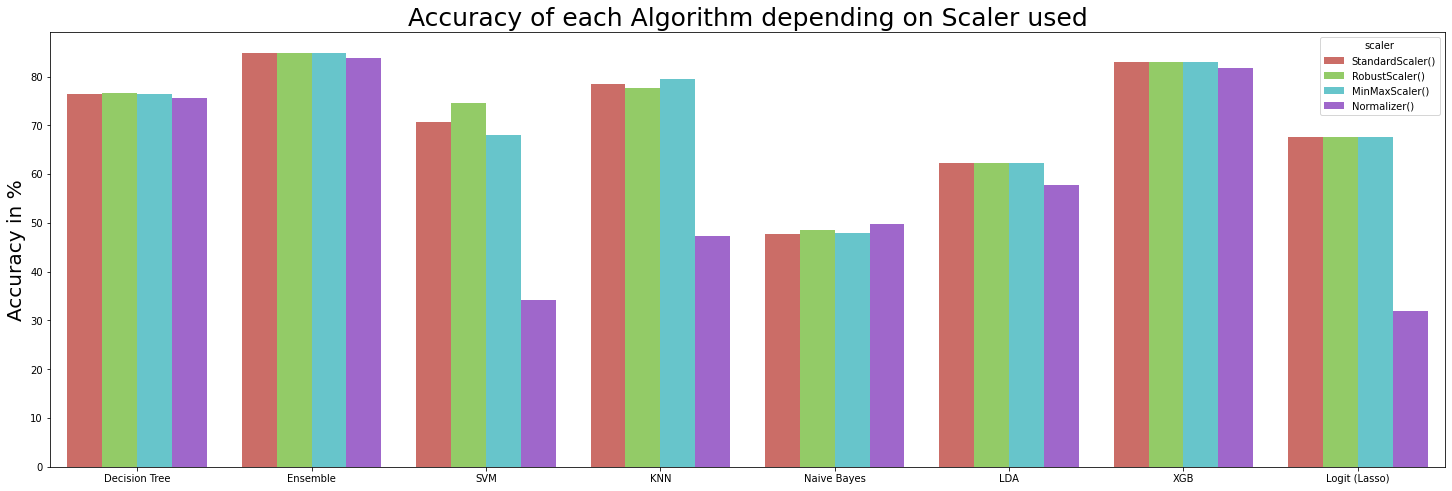

In [53]:
plt.figure(figsize = (25,8))
ax = sns.barplot(x=model_scores["model"], y=round(model_scores["accuracy"],1), hue = model_scores["scaler"], palette = "hls");
ax.set_xlabel("")
ax.set_ylabel("Accuracy in %", fontsize = 20)
ax.set_title("Accuracy of each Algorithm depending on Scaler used", fontsize = 25)

Tree based models are not affected by scaling. The models with highest potential are Random Forest or Ensemble (~ 85% accuracy), XGB (~ 82% accuracy) and KNN (~ 78% accuracy). 

### b. Tuning Models with Highest Potential
Even though the following models give great results: 
* RandomForestClassifier
* KNeighborsClassifier
* XGBClassifier

It was decided to keep for comparaison a distance based algorithm (KNeighborsClassifier) and a tree algorithm (RandomForestClassifier).

Creating hyperparameters grids for both algorithms:

In [54]:
param_grid_RandomForestClassifier = {
    "Algorithm__max_features": [0.5, 0.6, 0.8],
    "Algorithm__max_depth": [25, 50, 75],
    "Algorithm__min_samples_split": [2, 4, 8],
    "Algorithm__min_samples_leaf": [1, 2, 4],
    "Algorithm__random_state": [rand_state] 
}

param_grid_KNeighborsClassifier = {
    "Algorithm__n_neighbors": [1, 3, 5, 7],
    "Algorithm__weights": ['uniform', 'distance'],
}

Training and evaluating the two models with highest potential:

In [55]:
algorithms = {"Ensemble" : (RandomForestClassifier(), param_grid_RandomForestClassifier),
              "KNN" : (KNeighborsClassifier(), param_grid_KNeighborsClassifier)
             }

scalers=[]
models = []
scaler_used = []
scores=[]
best_param = []

for algo_name,algo_param in algorithms.items(): 
    
    if algo_name == "KNN": #If the algorithm is not tree based, it needs scaling
        scalers = [StandardScaler(), RobustScaler(), MinMaxScaler()]
        
        for scaler in scalers:
            transformer = ColumnTransformer(
            [
                (
                    str(scaler),
                    scaler,
                    best_features
                )
            ],
            remainder="passthrough"
            )

            pipe2 = Pipeline([
            ("scaler", transformer),
            ("Algorithm", algo_param[0])
            ])

            models.append(algo_name)
            scaler_used.append(scaler)

            grid_ = GridSearchCV(
                pipe2, 
                algo_param[1],
                scoring="accuracy", 
                cv=3,
                n_jobs=-1,
                verbose=2 
                )

            grid_.fit(x_train2, y_train)

            best_param.append(grid_.best_params_)
            scores.append(round(np.mean(cross_val_score(grid_, x_train2, y_train, cv=3))*100,2));
            
    else:
        pipe2 = Pipeline([
            ("Algorithm", algo_param[0])
            ])

        models.append(algo_name)
        scaler_used.append("None")

        grid_ = GridSearchCV(
            pipe2, 
            algo_param[1],
            scoring="accuracy", 
            cv=3,
            n_jobs=-1,
            verbose=2 
            )

        grid_.fit(x_train2, y_train)

        best_param.append(grid_.best_params_)
        scores.append(round(np.mean(cross_val_score(grid_, x_train2, y_train, cv=3))*100,2));

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits


In [56]:
#Saving scores in a dataframe
model_scores2 = pd.DataFrame({
    "model": models,
    "scaler" : scaler_used,
    "accuracy" : scores,
    "best_parameters": best_param
})
model_scores2

model            scaler  accuracy  \
0  Ensemble              None     84.31   
1       KNN  StandardScaler()     80.17   
2       KNN    RobustScaler()     80.00   
3       KNN    MinMaxScaler()     81.60   

                                     best_parameters  
0  {'Algorithm__max_depth': 25, 'Algorithm__max_f...  
1  {'Algorithm__n_neighbors': 1, 'Algorithm__weig...  
2  {'Algorithm__n_neighbors': 1, 'Algorithm__weig...  
3  {'Algorithm__n_neighbors': 1, 'Algorithm__weig...

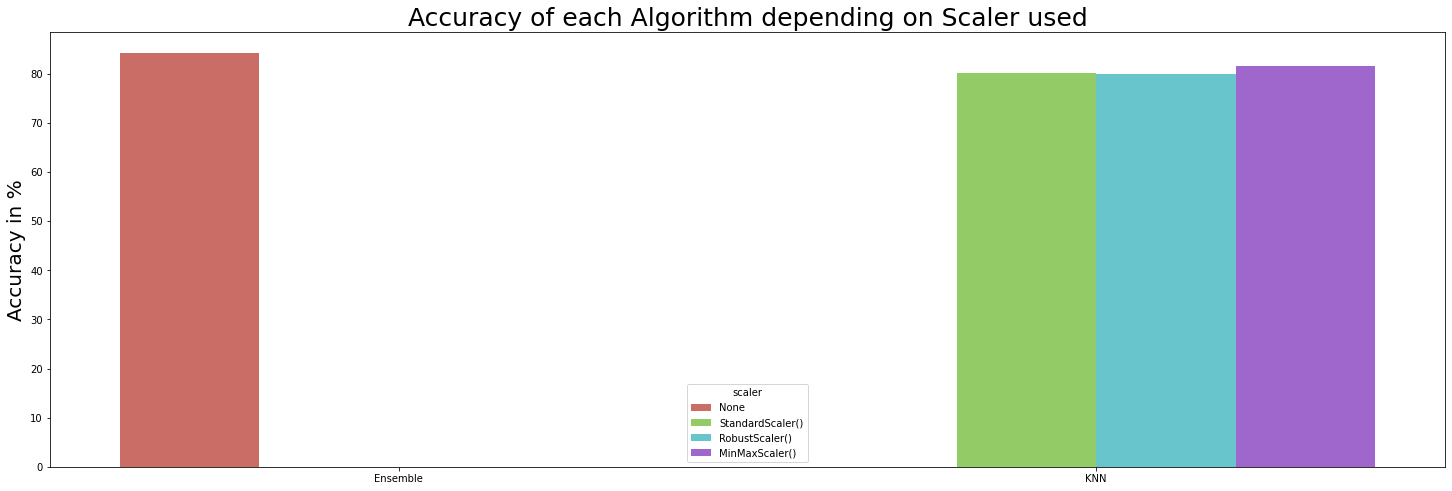

In [57]:
#Plotting Accuracies
plt.figure(figsize = (25,8))
ax = sns.barplot(x=model_scores2["model"], y=model_scores2["accuracy"], hue = model_scores2["scaler"], palette = "hls");
ax.set_xlabel("")
ax.set_ylabel("Accuracy in %", fontsize = 20)
ax.set_title("Accuracy of each Algorithm depending on Scaler used", fontsize = 25);

Random Forest (Ensemble) seems like the best model for our prediction with an accuracy of 84.3% against 81.6% for KNN with MinMax Scaler.

## 6) Best Model
### a. Training the Model
The final model that was chosen is the RandomForestClassifier().<br/>
A pipeline will be run using this algorithm using the best parameters from the GridSearchCV obtained in part 5b):

In [58]:
pipe_final = Pipeline([
("Algorithm", RandomForestClassifier())
])

pipe_final.set_params(**model_scores2["best_parameters"][0])
pipe_final.fit(x_train2, y_train)

Pipeline(steps=[('Algorithm',
                 RandomForestClassifier(max_depth=25, max_features=0.5,
                                        random_state=42))])

### b. Evaluating the Model
Predicting accuracy on training data (should be close to 100%):

In [59]:
y_train_pred = pipe_final.predict(x_train2)
acc_train = accuracy_score(y_train, y_train_pred)
prec_train = precision_score(y_train, y_train_pred, average = None)
rec_train = recall_score(y_train, y_train_pred, average = None)

print(f"Accuracy on training data: {round(acc_train*100,2)}%")
print(f"Precision on training data: {round(np.mean(prec_train*100),2)}%")
print(f"Recall on training data: {round(np.mean(rec_train*100),2)}%")

Accuracy on training data: 100.0%
Precision on training data: 100.0%
Recall on training data: 100.0%


Predicting accuracy on training data:

In [60]:
y_test_pred = pipe_final.predict(x_test2)
acc_test = accuracy_score(y_test, y_test_pred)
prec_test = precision_score(y_test, y_test_pred, average = None)
rec_test = recall_score(y_test, y_test_pred, average = None)

print(f"Accuracy on testing data: {round(acc_test*100,2)}%")
print(f"Precision on testing data: {round(np.mean(prec_test*100),2)}%")
print(f"Recall on testing data: {round(np.mean(rec_test*100),2)}%")

Accuracy on testing data: 85.73%
Precision on testing data: 85.22%
Recall on testing data: 85.45%


Actual vs Predicted for each Cover_Type:

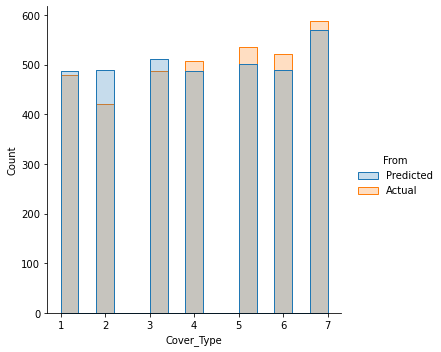

In [61]:
actual_vs_predicted = pd.DataFrame({
    "Cover_Type": list(y_test) + (list(y_test_pred)),
    "From" : ["Predicted"]*len(y_test) + ["Actual"]*len(list(y_test_pred)),
})

ax = sns.displot(actual_vs_predicted, x="Cover_Type", element="step", hue = "From");

Confusion Matrix:

Text(0.5, 1.0, '%')

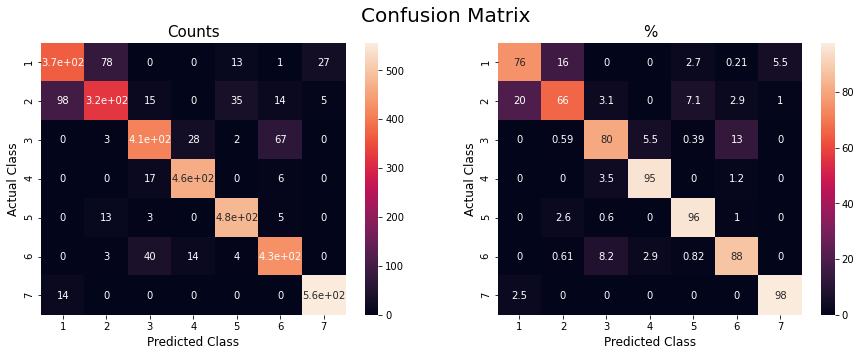

In [62]:
cm = confusion_matrix(y_test, y_test_pred)
cm2 = confusion_matrix(y_test, y_test_pred, normalize = 'true') 

fig, ax = plt.subplots(1,2,figsize = (15,5))
fig.suptitle("Confusion Matrix", fontsize = 20 )
sns.heatmap(cm, annot=True,
           xticklabels = [1, 2, 3, 4, 5, 6, 7],
           yticklabels = [1, 2, 3, 4, 5, 6, 7],
           ax = ax[0]
           )

ax[0].set_xlabel("Predicted Class", fontsize = 12)
ax[0].set_ylabel("Actual Class", fontsize = 12)
ax[0].set_title("Counts", fontsize = 15)

sns.heatmap(cm2*100, annot=True,
           xticklabels = [1, 2, 3, 4, 5, 6, 7],
           yticklabels = [1, 2, 3, 4, 5, 6, 7],
           ax = ax[1]
           )

ax[1].set_xlabel("Predicted Class", fontsize = 12)
ax[1].set_ylabel("Actual Class", fontsize = 12)
ax[1].set_title("%", fontsize = 15)

The Cover_Types that are the hardest to predict are Types 1, 2 and 3.

## 7) Predicting on the Final Test Set

### a. Preparing the Training and Test Sets
Train Set:

In [63]:
final_train_X = X2
final_train_Y = Y

Importing the Test Set:

In [64]:
test_set = pd.read_csv("test.csv")
test_id = test_set["Id"]

test_set.drop("Id",axis = 1,  inplace = True)

test_set.head()

Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0       2680     354     14                                 0   
1       2683       0     13                                 0   
2       2713      16     15                                 0   
3       2709      24     17                                 0   
4       2706      29     19                                 0   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                             2684   
1                               0                             2654   
2                               0                             2980   
3                               0                             2950   
4                               0                             2920   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0            196             214            156   
1            201             216            152   
2            206             208            137   
3            208             201            125   
4            210             195            115   

   Horizontal_Distance_To_Fire_Points  ...  Soil_Type31  Soil_Type32  \
0                                6645  ...            0            0   
1                                6675  ...            0            0   
2                                6344  ...            0            0   
3                                6374  ...            0            0   
4                                6404  ...            0            0   

   Soil_Type33  Soil_Type34  Soil_Type35  Soil_Type36  Soil_Type37  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Soil_Type38  Soil_Type39  Soil_Type40  
0            0            0            0  
1            0            0            0  
2            0            0            0  
3            0            0            0  
4            0            0            0  

[5 rows x 54 columns]

Preparing the Test Set:<br/>
*Note: No scaling required since the algorithm is tree based.*

In [65]:
#Adding the new features:
hypotenuse_distance_to_hydrology(test_set, test_set["Horizontal_Distance_To_Hydrology"], test_set["Vertical_Distance_To_Hydrology"])
illumination_coef(test_set, test_set["Hillshade_9am"] , test_set["Hillshade_Noon"], test_set["Hillshade_3pm"])
test_set.drop(["Hillshade_9am","Hillshade_Noon","Hillshade_3pm","Slope","Aspect","Horizontal_Distance_To_Hydrology","Vertical_Distance_To_Hydrology"], axis = 1,  inplace = True)

#Dropping unimportant features:
test_set = test_set[best_features]

### b. Setting up the Pipeline and Predicting

In [66]:
pipe_final2 = Pipeline([
("Algorithm", RandomForestClassifier())
])

pipe_final2.set_params(**model_scores2["best_parameters"][0])
pipe_final2.fit(X2, Y)

Y_final_pred = pipe_final2.predict(test_set)

### c. Results Overview

In [67]:
predicted_dist = pd.DataFrame({
    "Cover_Type": [1,2,3,4,5,6,7],
    "Count" : [list(Y_final_pred).count(1),list(Y_final_pred).count(2),list(Y_final_pred).count(3),list(Y_final_pred).count(4),list(Y_final_pred).count(5),list(Y_final_pred).count(6),list(Y_final_pred).count(7)]
})
predicted_dist.set_index("Cover_Type")

Count
Cover_Type        
1           212031
2           222857
3            35348
4             2411
5            30435
6            26421
7            36389

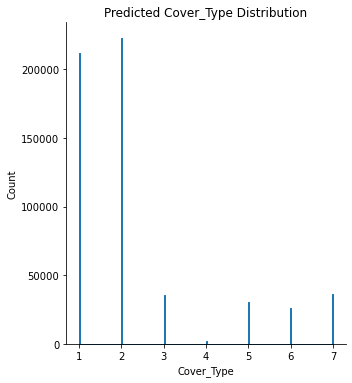

In [68]:
ax = sns.displot(Y_final_pred, element="step");
ax.set(xlabel='Cover_Type', title='Predicted Cover_Type Distribution');

### d. Writting the Prediction in a File

First you need to download the test file from the following link:
https://www.kaggle.com/competitions/forest-cover-type-prediction/data?select=test.csv

In [69]:
our_prediction = pd.DataFrame({
    "Id":  test_id,
    "Cover_Type" : list(Y_final_pred)
})

In [70]:
file_name = "Tree_Prediction.csv"

our_prediction.to_csv(file_name)